##**F217699 2023-2024 NLP COURSEWORK**

Starting with downloading all related libraries that is used for coursework

In [1]:
from numpy import array
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from pandas import DataFrame
from matplotlib import pyplot
import random
import nltk
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import rand
from sklearn.metrics.pairwise import cosine_similarity
from numpy import argsort
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 1) Datasets

Connecting all databases and google drive

In [2]:
#Connecting google drive to google colab
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"
!ls "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"
#Defining all data file locations
JewelleryReviewsSummarisationTargets = "JewelleryReviewsSummarisationTargets.csv"
JewelleryReviewsQueryRelevantID ="JewelleryReviewsQueryRelevantID.csv"
JewelleryReviewsLSA  = "JewelleryReviewsLSA.csv"

Mounted at /content/drive
JewelleryReviewsLSA.csv		     JewelleryReviewsQueryRelevantID.gsheet
JewelleryReviewsLSA.gsheet	     JewelleryReviewsSummarisationTargets.csv
JewelleryReviewsQueryRelevantID.csv  JewelleryReviewsSummarisationTargets.gsheet


Uploading CSV file into code as pandas df

In [3]:
import pandas as pd
# Give full file location
csv_file_path = data_path + JewelleryReviewsLSA
# Read CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

#2 Task Descriptions: Information Retrieval, Clustering, and Summarisation

##2.1 Pre-process the dataset.

In [4]:
# Lab source code is used to create cleand_doc function
# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()

	# convert to lower case
	tokens = [word.lower() for word in tokens]

 	# stemming of words
	from nltk.stem.porter import PorterStemmer
	porter = PorterStemmer()
	tokens = [porter.stem(word) for word in tokens]

	# remove punctuation from each token
	table = str.maketrans('', '', punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	return tokens

In [5]:
# Uploading query informations from CSV
query_csv_file_path = data_path + JewelleryReviewsQueryRelevantID

# Read CSV file into a DataFrame
df_query = pd.read_csv(query_csv_file_path)

querys = [] #This list is created to store queries clean versions
base_querys =[]#This list is created to store queries original versions

#The loop is created to store all queries
for i in range(len(df_query)-8):
  querys.append(' '.join(clean_doc(df_query.iloc[0,i+9])))
  base_querys.append(df_query.iloc[0,i+9])


# In this section i store all the relevant retrival quaries to make evaluation
query_answers = []#This list is created to store one query related comments locations.
query_answers_total = []#This list is created to store all queries related comments locations.
row = 0
#The loop is created for storing each queries answers
for col in range(8):
    while True:
      try:
        query_answers.append(int(df_query.iloc[row,col]))
      except:
        break
      row +=1
    row = 0
    query_answers_total.append(query_answers)
    query_answers = []

In [6]:
vocab = []# This list is created to store all cleaned tokens.
train_docs = []# This list is created to store all cleaned sentences.
for i in range(len(df)):
  vocab += clean_doc(df.iloc[i,1])
  train_docs.append(' '.join(clean_doc(df.iloc[i,1])))
vocab = list(set(vocab))#Here i remove the duplicates.

##2.2 Latent Semantic Indexing (LSI)


###2.2.a


Lab source codes is used for this section.

In [7]:
# prepare words encoding of docs
def prepare_data(train_docs, mode, vocab):
	# encode training data set
	vectorizer = CountVectorizer(vocabulary=vocab)
	transformer = TfidfTransformer(norm='l2')
	Xtrain = transformer.fit_transform(vectorizer.fit_transform(train_docs))
	return Xtrain

In [8]:
# preprocess query
def preprocess_query(review, mode, vocab):
	# clean
	tokens = clean_doc(review)
	# convert to line
	line = ' '.join(tokens)
	# encode
	vectorizer = CountVectorizer(vocabulary=vocab)
	transformer = TfidfTransformer(norm='l2')
	encoded = transformer.fit_transform(vectorizer.fit_transform([line]))
	return encoded



###2.2.b

In [9]:
Xtrain = prepare_data(train_docs, 'tfidf', vocab)#The data prepared in this section.
trunc_SVD_model = TruncatedSVD(n_components=50)#SVD model is created with 50 components.
approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)#Model is created.
print("Approximated Xtrain shape: " + str(approx_Xtrain.shape))

Approximated Xtrain shape: (200, 50)


###2.2.c

In [10]:
query_number = 0 #This value is created to track query number.
recall_list_total = []#This list is created to store all of the recall values.
precision_list_total =[]#This list is created to store all of the precision values.
for query in querys:#This process is applied for all of the queries.
  #query value is preprocessed.
  encoded_query = preprocess_query(query, 'tfidf', vocab)
  #SVD model is applied for the query value
  transformed_query = trunc_SVD_model.transform(encoded_query)
  #similarity matrix is created.
  similarities = cosine_similarity(approx_Xtrain, transformed_query)
  #Number of retrieval is defined as 10
  Top_n_reviews=10
  #Similarity matrix is converted to 1D dimension and sorted from max to min.
  indexes = np.argsort(similarities.flat)[::-1]

  recall_list = []#This list is created to store recall for certain query.
  precision_list =[]#This list is created to store precision for certain query.
  stop_loop = False #This boolen is created to understand if the recall reach 1 or not

  # In below I find how to understand the total recall number
  if len(query_answers_total[query_number]) < Top_n_reviews:
    #If total parameter that can be found is less then 10, make the recall number this value.
    recall_number = len(query_answers_total[query_number])
  else:
    #This loop checks maximum 10 values due to CW spesifications.
    recall_number = Top_n_reviews
  print(f"\nTop 10 most similar sentences in training set to: {query}")
  for i in range(Top_n_reviews):#Loop for queries.

    print(f"Cosine Similarity Score: {similarities[indexes[i]].item()}, Sentence: {df.iloc[indexes[i],1]}")
    print(df.iloc[indexes[i],0])
    #Next loop stops the process if recall is max.(No need the search for more)
    for f in recall_list:
      if f > 0.99:
        stop_loop = True
    if stop_loop:
      break

    #Next if else statement updates the recall and precision list depending on answers.
    if int(df.iloc[indexes[i],0]) in query_answers_total[query_number]:
      try:
        recall_list.append(float(1/recall_number + recall_list[-1]))
        precision_list.append(float((1 + (precision_list[-1]*len(precision_list))) / (len(precision_list)+1)))

      except:
        recall_list.append(float(1/recall_number))
        precision_list.append(1)
    else:
      try:
        precision_list.append(float(((precision_list[-1]*len(precision_list))) / (len(precision_list)+1)))
        recall_list.append(recall_list[-1])
      except:
        precision_list.append(0)
        recall_list.append(0)

  recall_list_total.append(recall_list)#Update the recal total list with last made recall list
  precision_list_total.append(precision_list)#Update the precision total list with last made precision list
  query_number += 1# Do for the next iteration.


Top 10 most similar sentences in training set to: ring great gift friend love
Cosine Similarity Score: 0.7290110808357925, Sentence: I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.
41876
Cosine Similarity Score: 0.6702745796097582, Sentence: my wife loves the ring, it was a great gift. extremelly cheap and high quality.
58481
Cosine Similarity Score: 0.6666219561926238, Sentence: I love this ring fits just right and I showed my daughter the ring and she loved it as well. Great for everyday wear and the price was great..
45278
Cosine Similarity Score: 0.6633287270302661, Sentence: I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring
56494
Cosine Similarity Score: 0.6492698762820652, Sentence: I love my birthstone and I wanted a piece of jewelry that symbolized the simple purity of the Blue Topaz. This ring did that for me. As a gift to myself for my birthday this year, it was definitely a

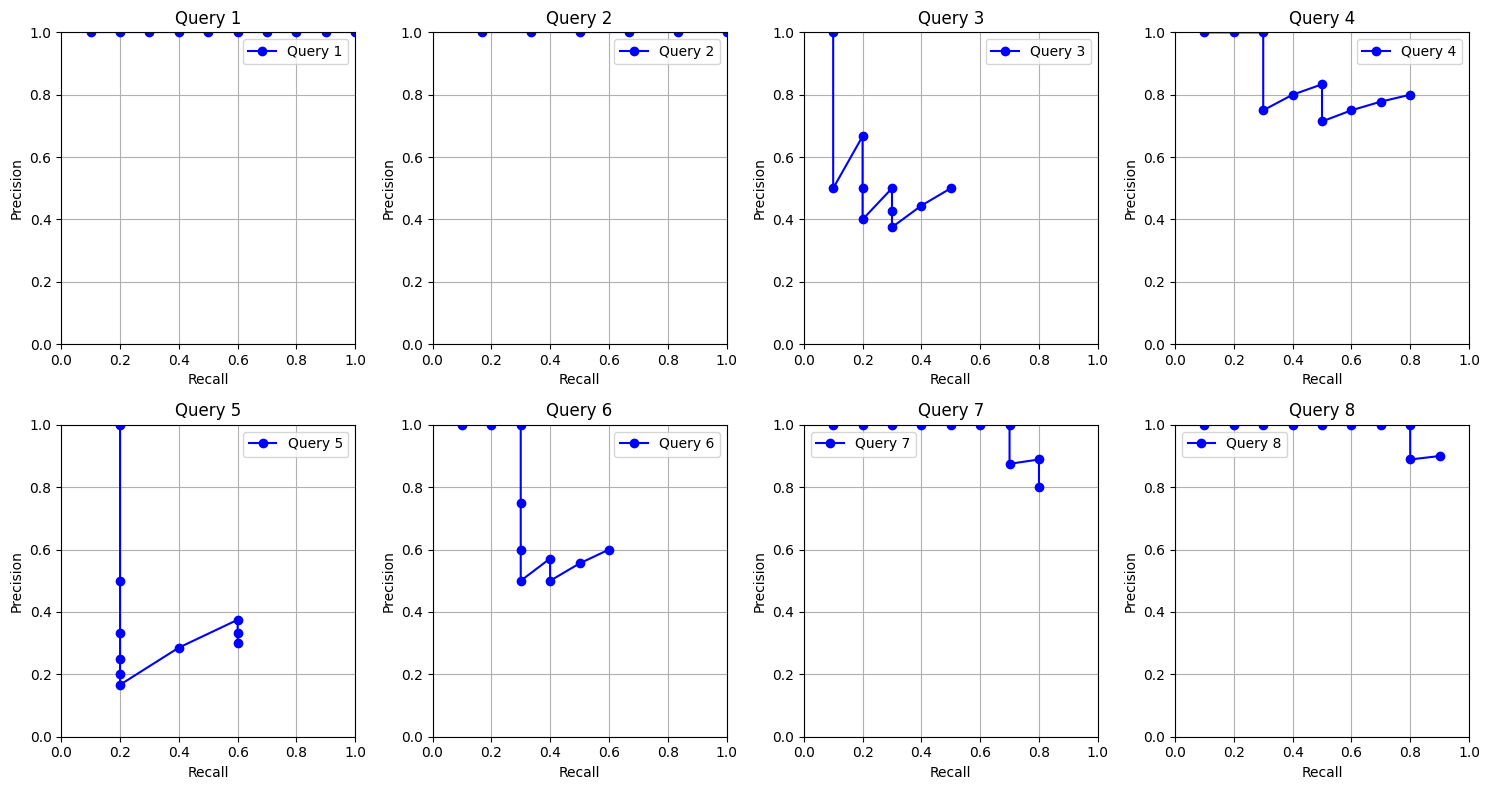

In [11]:
import matplotlib.pyplot as plt

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Loop through each set of data
for i in range(8):
    # Upload datas
    list1 = precision_list_total[i]
    list2 = recall_list_total[i]

    # Plotting in the corresponding subplot
    axes[i].plot(list2, list1, marker='o', linestyle='-', color='b', label=f'Query {i+1}')

    # Adding labels and title
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Query {i+1}')

    # Adding grid
    axes[i].grid(True)

    # Setting x-axis and y-axis limits to ensure values range from 0 to 1
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)

    # Show legend
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In summary for the LSI section; I have tried 8 queries and recieved at least 0.5 recall and 0.3 precision values. Two of the queries gave the max performans for recall and precision while two others gave almost max performans as well. The other 4 queries performed avarage values. As a result, model performed better than expectations with no fail queries.


##2.3 Neural information retrieval

###2.3.a

In [12]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 939.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [14]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained transformer model (e.g., 'paraphrase-MiniLM-L6-v2')
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# Encode training sentences
train_embeddings = model.encode(train_docs, convert_to_tensor=True)

neural_query_number = 0 #This value is created to track query number.
neural_recall_list_total = [] #This list is created to store all of the recall values.
neural_precision_list_total =[] #This list is created to store all of the precision values.

for query in querys:

  individual_sentence = query
  # Encode individual sentences
  individual_embedding = model.encode(individual_sentence, convert_to_tensor=True)

  # Calculate cosine similarity between the individual sentence and all training sentences
  neural_similarities = util.pytorch_cos_sim(individual_embedding, train_embeddings)[0]

  Top_nn_reviews = 10
  # Find the indices of the top 10 most similar sentences in the training set
  top_10_indices = neural_similarities.argsort(descending=True)[:Top_nn_reviews]


  neural_recall_list = [] #This list is created to store recall for certain query.
  neural_precision_list =[] #This list is created to store precision for certain query.
  stop_loop = False #This boolen is created to understand if the recall reach 1 or not

  # In below I find how to understand the total recall number
  if len(query_answers_total[neural_query_number]) < Top_nn_reviews:
    neural_recall_number = len(query_answers_total[neural_query_number])
  else:
    neural_recall_number = Top_nn_reviews
  # Display the top 10 most similar sentences in the training set for the individual sentence
  print(f"\nTop 10 most similar sentences in training set to: {individual_sentence}")
  for index in top_10_indices:

    #Next loop stops the process if recall is max.(No need the search for more)
    for f in neural_recall_list:
      if f > 0.99:
        stop_loop = True
    if stop_loop:
      break

    print(f"Cosine Similarity Score: {neural_similarities[index].item()}, Sentence: {df.iloc[int(index),1]}")
    print(df.iloc[int(index),0])

    #Next if else statement updates the recall and precision list depending on answers.
    if int(df.iloc[int(index),0]) in query_answers_total[neural_query_number]:
      try:
        neural_recall_list.append(float(1/neural_recall_number + neural_recall_list[-1]))
        neural_precision_list.append(float((1 + (neural_precision_list[-1]*len(neural_precision_list))) / (len(neural_precision_list)+1)))

      except:
        neural_recall_list.append(float(1/neural_recall_number))
        neural_precision_list.append(1)
    else:
      try:
        neural_precision_list.append(float(((neural_precision_list[-1]*len(neural_precision_list))) / (len(neural_precision_list)+1)))
        neural_recall_list.append(neural_recall_list[-1])
      except:
        neural_precision_list.append(0)
        neural_recall_list.append(0)

  neural_recall_list_total.append(neural_recall_list)#Update the recal total list with last made recall list
  neural_precision_list_total.append(neural_precision_list)#Update the precision total list with last made precision list
  neural_query_number += 1# Do for the next iteration.


Top 10 most similar sentences in training set to: ring great gift friend love
Cosine Similarity Score: 0.8168299198150635, Sentence: I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.
41876
Cosine Similarity Score: 0.7400156259536743, Sentence: my wife loves the ring, it was a great gift. extremelly cheap and high quality.
58481
Cosine Similarity Score: 0.6964983940124512, Sentence: This ring has such a good sparkle and it looks like a ring that should cost 10x the amount. Makes a great gift for someone on a budget. My girlfriend loves it.
34523
Cosine Similarity Score: 0.658684492111206, Sentence: I got the ring as a promise ring for my girlfriend for Christmas and she loved it. Definitely a great value.
36164
Cosine Similarity Score: 0.6483923196792603, Sentence: I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring
56494
Cosine Similarity Score: 0.6300880908966064, Sentence: I love the ri

###2.3.b

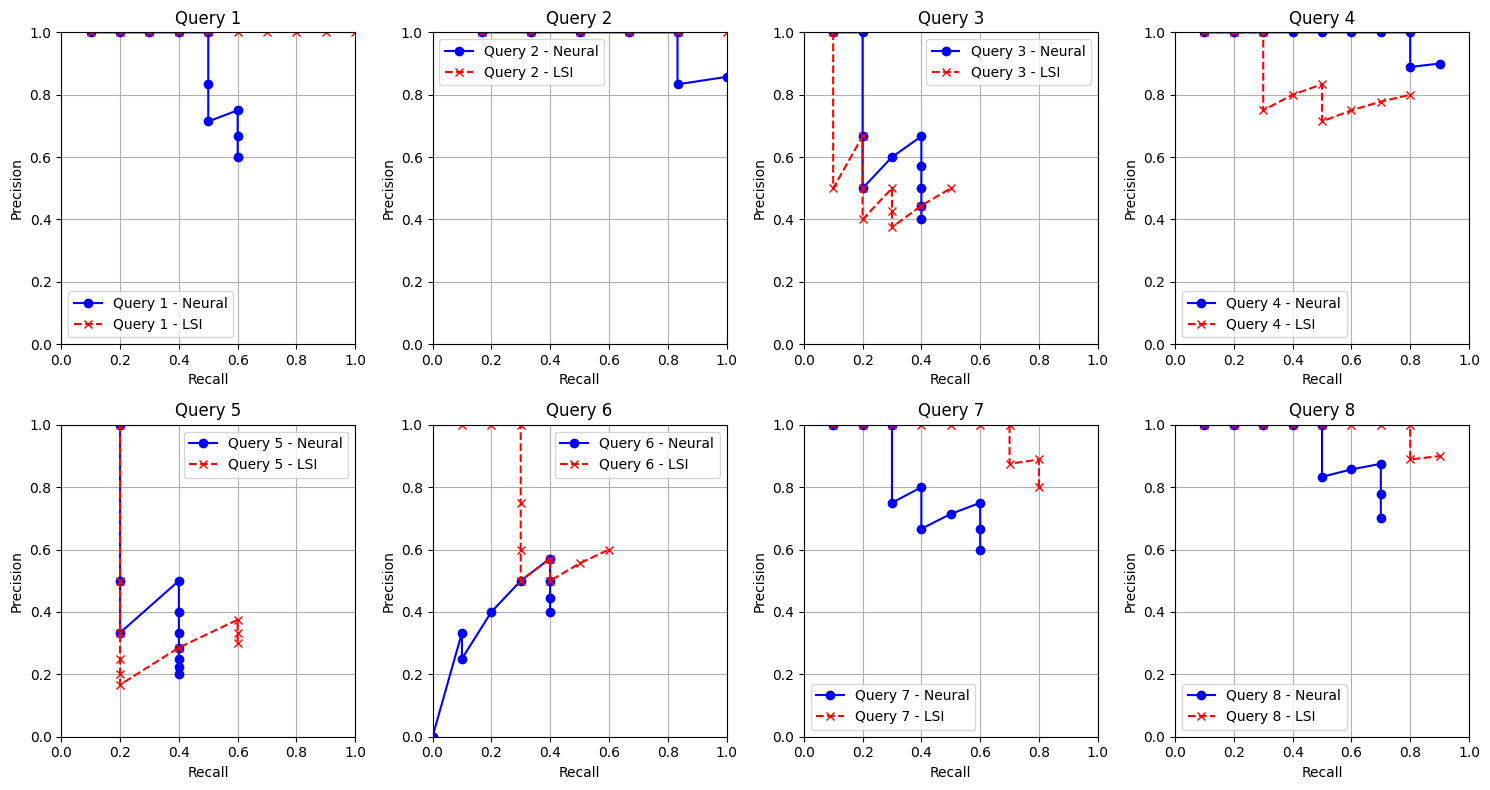

In [15]:
import matplotlib.pyplot as plt

# Combine the precision and recall lists for each query
combined_lists = zip(neural_precision_list_total, neural_recall_list_total, precision_list_total, recall_list_total)

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Loop through each set of data
for i, (list1, list2, list3, list4) in enumerate(combined_lists):
    # Plotting in the corresponding subplot
    axes[i].plot(list2, list1, marker='o', linestyle='-', color='b', label=f'Query {i+1} - Neural')
    axes[i].plot(list4, list3, marker='x', linestyle='--', color='r', label=f'Query {i+1} - LSI')

    # Adding labels and title
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Query {i+1}')

    # Adding grid
    axes[i].grid(True)

    # Setting x-axis and y-axis limits to ensure values range from 0 to 1
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)

    # Show legend
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


When LSI and the neural information retrieval model are compared, following observation can be made;
1.   It can be seen that almost all of the queries **Recall values** are much better with LSI.(Just in one example NIR preformed better.)
2.   It can be seen that almost all of the queries **Precision values** are much better with LSI.(Just in one example NIR preformed better.)
*   Overall result is that LSI performed much better comparing NIR.







###2.3.c

In [16]:
def interface(individual_sentence,number_of_similar_sentences):
    individual_sentence = (' '.join(clean_doc(str(individual_sentence))))
    # Encode individual sentences
    individual_embedding = model.encode(individual_sentence, convert_to_tensor=True)

    # Calculate cosine similarity between the individual sentence and all training sentences
    neural_similarities = util.pytorch_cos_sim(individual_embedding, train_embeddings)[0]

    Top_nn_reviews = number_of_similar_sentences
    # Find the indices of the top wanted most similar sentences in the training set
    top_10_indices = neural_similarities.argsort(descending=True)[:Top_nn_reviews]
    print( "Original sentence given by user: " + str(individual_sentence) +"\n")
    for index in top_10_indices: #Give the informations via loop.
      print(f"Cosine Similarity Score: {round(neural_similarities[index].item(),2)}, Sentence: {df.iloc[int(index),1]}")
      print("ID Number: " + str(df.iloc[int(index),0]))

In [17]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

def query_interface():
    # Create widgets
    sentence_input = widgets.Text(
        value='',
        placeholder='Enter a sentence to see similar',
        description='Sentence:',
        disabled=False
    )

    results_input = widgets.IntText(
        value=5,
        description='Num Results:',
        disabled=False
    )

    #Creating buttons
    submit_button = widgets.Button(description='Submit')
    exit_button = widgets.Button(description='Exit')

    # Function to handle button click event
    def on_button_click(b):
        # Clear the previous screen.
        clear_output(wait=True)
        #Call the query_interface function again the display buttons
        query_interface()
        #Take the values that user gives
        query_sentence = sentence_input.value
        num_results = results_input.value
        #use the interface function to make calculations
        results = interface(query_sentence, num_results)

        # Display results
        print(results)

    # Function to handle exit button click event
    def on_exit_click(b):# Close everyting and finish the process
        clear_output(wait=True)
        submit_button.close()
        exit_button.close()
        sentence_input.close()
        results_input.close()
        print("Exited")

    # Attach button click event handlers
    submit_button.on_click(on_button_click)
    exit_button.on_click(on_exit_click)

    # Arrange buttons in a horizontal box layout
    buttons_box = widgets.HBox([submit_button, exit_button])

    # Arrange widgets in a vertical box layout
    interface_box = widgets.VBox([sentence_input, results_input, buttons_box])

    # Display the interface
    display(interface_box)

# Call the interface function
query_interface()


Original sentence given by user: love thi ring

Cosine Similarity Score: 0.84, Sentence: I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.
ID Number: 10535
Cosine Similarity Score: 0.84, Sentence: I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.
ID Number: 28250
Cosine Similarity Score: 0.76, Sentence: This ring is perfect I say why spend thousands when you don't have to? The ring shines perfectly I love this ring!
ID Number: 33858
Cosine Similarity Score: 0.75, Sentence: I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring
ID Number: 56494
Cosine Similarity Score: 0.74, Sentence: I love the ring and suggest every girl should have this ring in their jewelry collection.
ID Number: 6522
Cosine Similarity Score: 0.74, Sentence: I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this r

##2.4 Clustering and analysis

###2.4.a - 2.4.b

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def clustering(sentences,based_sentences):
    # Load a pre-trained sentence embedding model
  model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

  # Generate sentence embeddings
  embeddings_clus = model.encode(sentences)

  # This section is for selecting cluster number
  silhouette_scores = []
  possible_cluster_values = range(3, 11)  # Start from 2 clusters
  for num_clusters in possible_cluster_values:
    try:
      kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
      cluster_labels = kmeans.fit_predict(embeddings_clus)
      silhouette_avg = silhouette_score(embeddings_clus, cluster_labels)
      silhouette_scores.append(silhouette_avg)
    except:
      break
  # Automatically determine the number of clusters based on silhouette score
  print(silhouette_scores)
  optimal_num_clusters = np.argmax(silhouette_scores) + 3  # Add 2 because we started from 2 clusters
  print("Optimal Number of Clusters:", optimal_num_clusters)

  # Perform clustering using KMeans
  num_clusters = optimal_num_clusters
  kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
  cluster_labels = kmeans.fit_predict(embeddings_clus)


  cluster_list_final =[]# This list is created to store clustered sentences for all querys
  # Print the clusters
  for cluster_id in range(num_clusters):
      cluster_sentences = np.array(based_sentences)[cluster_labels == cluster_id]
      print(f"Cluster {cluster_id + 1}:")
      print("\n".join(str(cluster_sentences).lower().split("\n")))
      print("\n")
      cluster_list =[]# This list is created to store clustered sentences for each query
      for t in range(len(cluster_sentences)):
        cluster_list.append(str(cluster_sentences[t]).lower())
      cluster_list_final.append(cluster_list)
  # Create the final output cluster list

  # Return the output values to use them analyzing count words and count sentence
  return num_clusters, cluster_list_final

In [43]:
  def retrieval(query_clus,Top_n_reviews_clus=50):
    #This function is used to retrieve most similar sentences.

    #Preprocess query data
    encoded_query_clus = preprocess_query(query_clus, 'tfidf', vocab)
    print(encoded_query_clus.shape)
    #Apply SVD to query data
    transformed_query_clus = trunc_SVD_model.transform(encoded_query_clus)

    print("Query shape: " + str(transformed_query_clus.shape))
    #Find similarities between query and base data approx_Xtrain(previously calculated)
    similarities_clus = cosine_similarity(approx_Xtrain, transformed_query_clus)
    print("Similarities shape: " + str(similarities.shape))

    #Sort the most similar data from high to low
    indexes_clus = np.argsort(similarities_clus.flat)[::-1]

    output=[] #This list is created to store similar data's clean version
    output_for_based_data =[] #This list is created to store similar data's original version
    print("\n" + "Original query sentence: " + query_clus)

    for i in range(Top_n_reviews_clus):
      # Store all cleaned and original versions
      output_for_based_data.append(df.iloc[indexes_clus[i],1])
      output.append(train_docs[indexes_clus[i]])
    #return similar values list in both version cleaned and original
    return output,output_for_based_data

**TEST SECTION**

In [45]:
#In this part clustering function is tried with one of the query in list with a number of wanted retrieval
test = retrieval(querys[0],40)
rn,rt = clustering(test[0],test[1])

(1, 1017)
Query shape: (1, 50)
Similarities shape: (200, 1)

Original query sentence: ring great gift friend love
[0.1112721, 0.1153857, 0.11002026, 0.1248456, 0.112570025, 0.113445595, 0.09203024, 0.08636115]
Optimal Number of Clusters: 6
Cluster 1:
["i bought this as a gift for a friends birthday and she loved it. it's a beautifull ring."
 'i got this ring as a gift from my boyfriend and i love it. the only thing is that if the rings are not position correctly it pinches the skin.'
 'my only wish on this ring is- i wish the cut potrion went all the way around the ring. other than that a great very comfortable ring.'
 'my husband loves it only thing is you cant have this ring resized due to the way the ring is made'
 'my second engagement ring got it on my birthday i love this nice and shinny lol must buy ring for anyone'
 'i love the ring its not a ring that you would want to wear as an everyday ring the claws that hold the stone in are very sharp and get stuck on things and have scr

###2.4.c

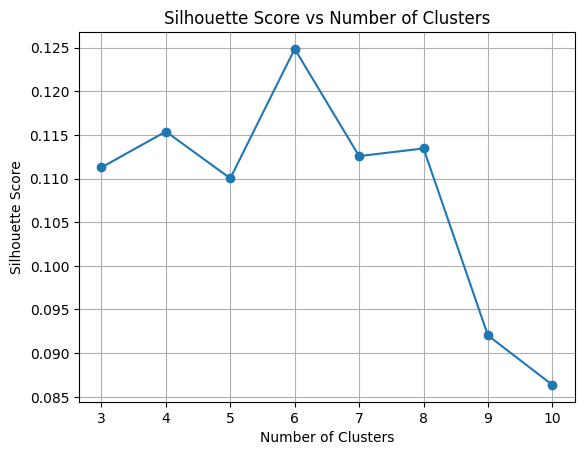

Optimal Number of Clusters: 6


In [52]:
import matplotlib.pyplot as plt

embeddings = model.encode(test[0])#I take same list in the previous example to show clustering performance
silhouette_scores = []#Store all of the clustering number scores in this list
possible_cluster_values = range(3, 11)  # Start from 2 clusters
#In next loop i check scores for all of the cluster number between 2 and 11
for num_clusters in possible_cluster_values:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)# Set the model
    cluster_labels = kmeans.fit_predict(embeddings)#Train the model
    silhouette_avg = silhouette_score(embeddings, cluster_labels)#Find the score
    silhouette_scores.append(silhouette_avg)#Save the scores

# Plot the silhouette scores
plt.plot(possible_cluster_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Automatically determine the number of clusters based on silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 3  # Add 2 because we started from 2 clusters
print("Optimal Number of Clusters:", optimal_num_clusters)

###2.4.d

In [22]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def Clustering_interface():
    # Create widgets
    sentence_input = widgets.Text(
        value='',
        placeholder='Enter a sentence to see similar in clustered',
        description='Sentence:',
        disabled=False
    )

    results_input = widgets.IntText(
        value=50,
        description='Num Results:',
        disabled=False
    )

    # Creating buttons
    submit_button = widgets.Button(description='Submit')
    exit_button = widgets.Button(description='Exit')

    # Function to handle button click event
    def on_button_click(b):
        # Clear the previous output
        clear_output(wait=True)
        display(interface_box)
        # Take the values that user gives
        query_sentence = sentence_input.value
        num_results = results_input.value
        # Call function to process the query and display results
        try:
            init = retrieval(query_sentence, num_results)
            clustering(init[0], init[1])
        except:
            print("Please give a larger number to be able to make better classification")
            print("\n"+"Since there is no sense to cluster less than 3 values")

    # Function to handle exit button click event
    def on_exit_click(b):
        # Clear the previous output
        clear_output(wait=True)
        # Close widgets
        submit_button.close()
        exit_button.close()
        sentence_input.close()
        results_input.close()
        print("Exited")

    # Attach button click event handlers
    submit_button.on_click(on_button_click)
    exit_button.on_click(on_exit_click)

    # Arrange buttons in a horizontal box layout
    buttons_box = widgets.HBox([submit_button, exit_button])

    # Arrange widgets in a vertical box layout
    interface_box = widgets.VBox([sentence_input, results_input, buttons_box])

    # Display the interface
    display(interface_box)

# Call the interface function
Clustering_interface()


(1, 1017)
Query shape: (1, 50)
Similarities shape: (200, 1)

Original query sentence: love this ring
[0.068257645, 0.0916679, 0.09229227, 0.06923265, 0.07108028, 0.08551893, 0.0688938, 0.08343823]
Optimal Number of Clusters: 5
Cluster 1:
["i do love this ring and i wear it all the time. i bought it to wear when my husband and i go on vacation so i don't have to worry about losing my real ring. the stone is already lose but it is a $50 ring and not a $5000 ring. almost every time i leave the house i get a compliment on this ring. my mom cannot tell the different between this ring and my real wedding ring. it is a little bulkier then the picture leads one to believe, but it is still a wonderful ring. if anything happens and the stone does fall out, i will probably buy another ring because of how much i love this ring."
 'i reciently lost a ring very much like this one and was searching high and low for another ring to replace the one i lost and came across this ring. this ring is absolut

###2.4.e

In [53]:
import re

def get_most_used_words(paragraph,number_of_cluster, top_n=5):

  query_info = {}
  for i in range(number_of_cluster):

      pr = paragraph[i]
      length = len(paragraph[i])

      # Convert the paragraph to lowercase
      pr = str(pr).lower()

      # Remove non-alphabetic characters and split into words
      words = re.findall(r'\b\w+\b', pr)

      # Remove stop words
      stop_words = set(stopwords.words('english'))
      words = [word for word in words if word not in stop_words]

      # Use Counter to count the occurrences of each word
      word_counts = Counter(words)

      # Get the most common words
      most_common_words = word_counts.most_common(top_n)

      count_list=[]
      word_list=[]
      for word, count in most_common_words:
        #print(f"{word}: {count} times")
        count_list.append(count)# Create a list to store count sentence values
        word_list.append(word)# Create a list to store count word values



      query_name = f"Cluster {i}"
      # Add values to the dictionary for the current query
      query_info[query_name] = {
          "num_sentences": length,
          "common_words": [(word, count) for word, count in zip(word_list, count_list)]
    }
  return query_info
most_used_words = get_most_used_words(rt,rn)



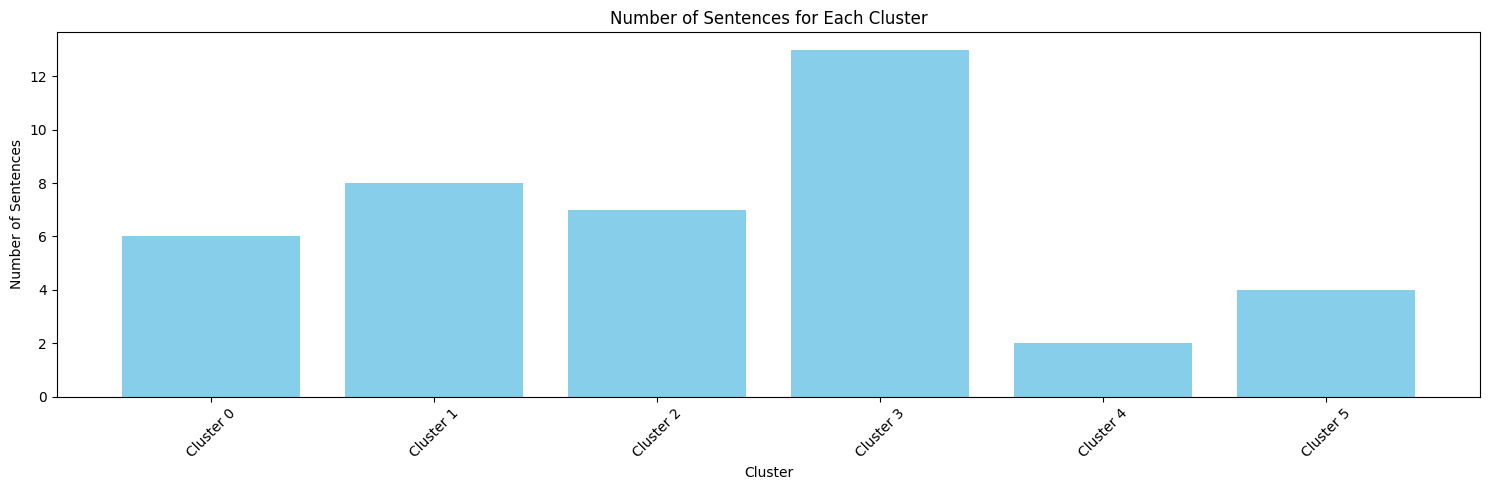

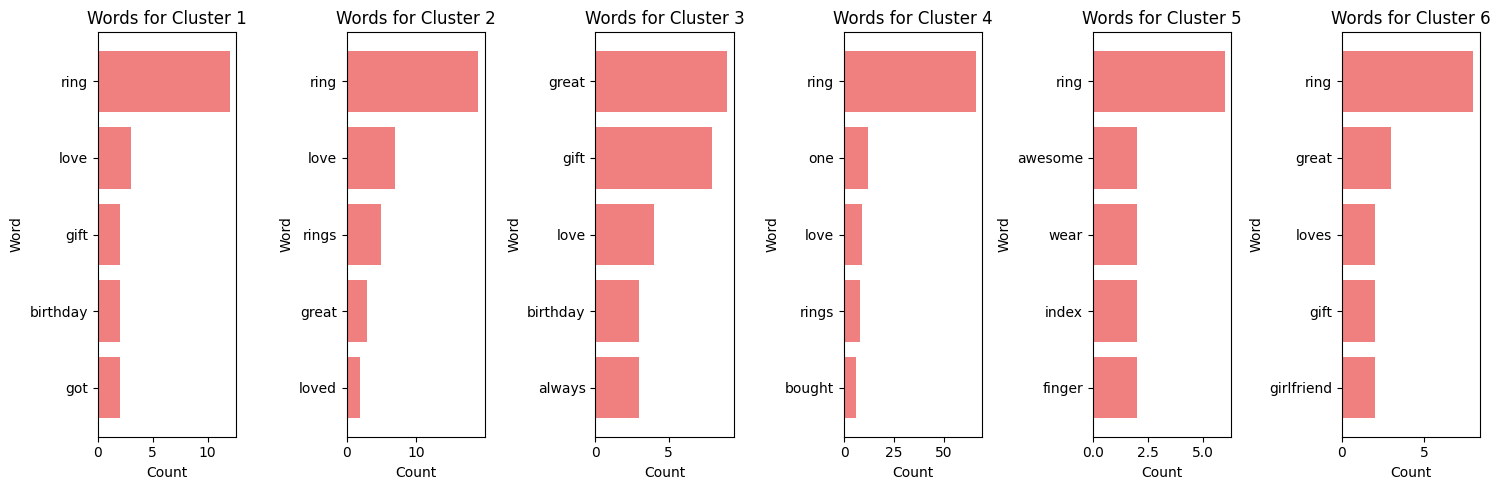

In [65]:
import matplotlib.pyplot as plt

def plot_query_info(query_info):
    # Extract query names, number of sentences, and common words
    query_names = list(query_info.keys())
    num_sentences = [info['num_sentences'] for info in query_info.values()]
    common_words = [info['common_words'] for info in query_info.values()]

    # Plot number of sentences
    plt.figure(figsize=(15, 5))
    plt.bar(query_names, num_sentences, color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Sentences')
    plt.title('Number of Sentences for Each Cluster')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot common words
    plt.figure(figsize=(15, 5))
    # Plot all common words in a loop
    for i, words in enumerate(common_words):
        plt.subplot(1, len(query_names), i+1)
        word_counts = [word[1] for word in words]
        word_labels = [word[0] for word in words]
        plt.barh(word_labels, word_counts, color='lightcoral')
        plt.xlabel('Count')
        plt.ylabel('Word')
        plt.title(f'Words for Cluster {i+1}')
        plt.gca().invert_yaxis()  # Invert y-axis to display top words first

    plt.tight_layout()
    plt.show()

# Plot query information
plot_query_info(most_used_words)


##2.5  Summarise topics within clusters of search results

###2.5.a

For the summary section, the output of the 2.4.b section is used. There is already clustered text created in that section, in the next section summary for these clusters will be generated.

In [47]:
#In this section the data for the summary is prepared as one string.
t =""#It is created to store each clustered value.
all_clustered_variable=[]#This list is created to store all t values together.
#For loop is created to store all individuals cluster values in a list as strings.
for s in range(len(rt)):
  for i in range(len(rt[s])):
    t += (rt[s][i])
  all_clustered_variable.append(t)

####2.5.a.1 Abstractive Model 1

In [26]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load pre-trained model and tokenizer
model_name_T5 = "t5-small"
tokenizer_T5 = T5Tokenizer.from_pretrained(model_name_T5)
model_T5 = T5ForConditionalGeneration.from_pretrained(model_name_T5)

#Create a function to use T5 summarizer again and again
def T5(input_text):
  # Tokenize the input text
  inputs = tokenizer_T5.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True)

  # Generate summary
  summary_ids = model_T5.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

  # Decode and print the summary
  summary = tokenizer_T5.decode(summary_ids[0], skip_special_tokens=True)
  return str(summary)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

####2.5.a.2 Abstractive Model 2

In [27]:
#Uploading neccesary libraries
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch
#Download google pegasus model
model_name_pegasus = "google/pegasus-xsum"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer_pegasus = PegasusTokenizer.from_pretrained(model_name_pegasus)
model_pegasus = PegasusForConditionalGeneration.from_pretrained(model_name_pegasus).to(device)
#Create a function to use this model again and again
def pegasus_summary(text):
  batch = tokenizer_pegasus(text, truncation=True, padding="longest", return_tensors="pt").to(device)
  translated = model_pegasus.generate(**batch)
  tgt_text = tokenizer_pegasus.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

####2.5.a.3 Extractive Model 1

In [28]:
#Download the neccesary library
%cd /content/
!pip install -q bert-extractive-summarizer
from summarizer import Summarizer
#Create the summarizer model
model_BERTSUM = Summarizer()
#Create a function to use this model again and again
def BERTSUM(text):

  # Summarize the text
  summary = model_BERTSUM(text, num_sentences=3)

  # Print the summary
  return summary


/content


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#### 2.5.a.4 Extractive Model 2

In [29]:
#Download the neccesary library
%cd /content/
!pip install -U -q sentence-transformers
from summarizer.sbert import SBertSummarizer
#Create the summarizer model
model_SBERT = SBertSummarizer('paraphrase-MiniLM-L6-v2')
#Create a function to use this model again and again
def SBERT(text):
  # Summarize the text
  summary = model_SBERT(text, num_sentences=3)
  # Print the summary
  return summary


/content


In [51]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#This warning ignore is added to avoid one of the future warning about
#kmeans version which have been used in downloaded library

#This function is created to use in this section also following sections to create summaries
def summary_creator_4_model(all_clustered_variable,rt):
  #Create initially empty summary lists.
  pegasus_list = []
  T5_list = []
  SBERT_list = []
  BERTSUM_list = []

  #This loop is use to take all summaries in the cluster
  for i in range(len(rt)):
    pegasus_list.append(pegasus_summary(all_clustered_variable[i]))
    T5_list.append(T5(all_clustered_variable[i]))
    SBERT_list.append(SBERT(all_clustered_variable[i]))
    BERTSUM_list.append(BERTSUM(all_clustered_variable[i]))
  #This loop is created to remove "[]" value which is created inside of pegasus summarizer function
  for i in range(len(pegasus_list)):
    a = str(pegasus_list[i]).replace('["',"")
    a=  a.replace('"]',"")
    pegasus_list[i] = a
  return pegasus_list,T5_list,SBERT_list,BERTSUM_list
#Use this function to get all cluster summaries.
pegasus_list,T5_list,SBERT_list,BERTSUM_list = summary_creator_4_model(all_clustered_variable,rt)
#Print the summary
for i in range(len(pegasus_list)):
    print("\n" + str(i+1)+". cluster original value: "+"\n")
    print(all_clustered_variable[i]+"\n")
    print("ABSTRACTIVE MODELS: "+"\n")
    print("Summary for PEGASUS: " + "\n")
    print(pegasus_list[i])
    print("\n"+"Summary for T5: " + "\n")
    print(T5_list[i])
    print("\n" + "EXTRACTIVE MODELS:" + "\n")
    print("\n"+"Summary for SBERT: " + "\n")
    print(SBERT_list[i])
    print("\n"+"Summary for BERTSUM: " + "\n")
    print(BERTSUM_list[i])


1. cluster original value: 

i bought this as a gift for a friends birthday and she loved it. it's a beautifull ring.i got this ring as a gift from my boyfriend and i love it. the only thing is that if the rings are not position correctly it pinches the skin.my only wish on this ring is- i wish the cut potrion went all the way around the ring. other than that a great very comfortable ring.my husband loves it only thing is you cant have this ring resized due to the way the ring is mademy second engagement ring got it on my birthday i love this nice and shinny lol must buy ring for anyonei love the ring its not a ring that you would want to wear as an everyday ring the claws that hold the stone in are very sharp and get stuck on things and have scratched me

ABSTRACTIVE MODELS: 

Summary for PEGASUS: 

I bought this ring as a gift for a friend's birthday and she loved it.

Summary for T5: 

i bought this ring as a gift from my boyfriend and i love it. the only thing is that if the rings

###2.5.b

In [55]:
def T5_title(input_text):
  # Tokenize the input text
  inputs = tokenizer_T5.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True)

  # Generate summary
  summary_ids = model_T5.generate(inputs, max_length=10, min_length=1, length_penalty=2.0, num_beams=4, early_stopping=True)

  # Decode and print the summary
  summary = tokenizer_T5.decode(summary_ids[0], skip_special_tokens=True)
  print("Generated title:", summary)

In [56]:
#This function is created to create a title for each summarized value.
def general_title_generator(pegasus_list,T5_list,SBERT_list,BERTSUM_list,all_clustered_variable):

  #This loop is created to create title for each summary on show them
  for i in range(len(pegasus_list)):
    print("\n" +str(i+1)+". CLUSTER ORIGINAL TEXT: "+"\n")
    print(all_clustered_variable[i]+"\n")
    print("ABSTRACTIVE MODELS: "+"\n")
    print("PEGASUS:")
    print(pegasus_list[i])
    T5_title(str(pegasus_list[i]))
    print("\n"+"T5: ")
    print(T5_list[i])
    T5_title(str(T5_list[i]))
    print("\n"+"EXCTRACTIVE MODELS: "+"\n")
    print("SBERT:")
    print(SBERT_list[i])
    T5_title(str(SBERT_list[i]))
    print("\n"+"BERTSUM:")
    print(BERTSUM_list[i])
    T5_title(str(BERTSUM_list[i]))
  print("\n" + "ALL PROCESS IS FINISHED")
#Call the function in this section
general_title_generator(pegasus_list,T5_list,SBERT_list,BERTSUM_list,all_clustered_variable)


1. CLUSTER ORIGINAL TEXT: 

i bought this as a gift for a friends birthday and she loved it. it's a beautifull ring.i got this ring as a gift from my boyfriend and i love it. the only thing is that if the rings are not position correctly it pinches the skin.my only wish on this ring is- i wish the cut potrion went all the way around the ring. other than that a great very comfortable ring.my husband loves it only thing is you cant have this ring resized due to the way the ring is mademy second engagement ring got it on my birthday i love this nice and shinny lol must buy ring for anyonei love the ring its not a ring that you would want to wear as an everyday ring the claws that hold the stone in are very sharp and get stuck on things and have scratched me

ABSTRACTIVE MODELS: 

PEGASUS:
I bought this ring as a gift for a friend's birthday and she loved it.
Generated title: ring was a gift for a

T5: 
i bought this ring as a gift from my boyfriend and i love it. the only thing is that i

###2.5.c

In [57]:
#importing necesarry libraries
from matplotlib import pyplot as plt
import numpy as np
!pip install nltk bert-score datasets transformers sumy
!pip install rouge_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from bert_score import score as bert_score
import nltk

nltk.download('punkt')
nltk.download('wordnet')

#This function is build to show evaluation values for each clustering libraries with using 1. clustered value answer as example
def evaluation_summary(summary_texts):
  # Lists to store scores for each metric, for plotting purposes
  bleu_scores = []
  meteor_scores = []

  targets = [
  """The ring is well-loved as a gift for birthdays or special occasions, appreciated
   for its beauty and comfort. However, there are some considerations, such as the inability
    to resize the ring due to its design and the sharp claws that hold the stone, which can be
     uncomfortable for everyday wear. Overall, it's a shiny and attractive ring that makes a great gift option."""
  ]

  matched_targets = targets[:len(summary_texts)]
  # BLEU Score Calculation
  print("BLEU Scores:")
  chencherry = SmoothingFunction()  # Initialize smoothing function for BLEU calculation to handle zero counts
  for i, (target, summary_text) in enumerate(zip(targets, summary_texts), 1):
      # Calculate BLEU score for each summary-target pair
      bleu_score = sentence_bleu([target.split()], summary_text.split(), smoothing_function=chencherry.method1)
      print(f"Summary {i}: {bleu_score}")
      bleu_scores.append(bleu_score)  # Store the calculated BLEU score

  # METEOR Score Calculation
  print("\nMETEOR Scores:")
  for i, (target, summary_text) in enumerate(zip(targets, summary_texts), 1):
      # Tokenize the summary and target texts for METEOR calculation
      tokenized_summary = word_tokenize(summary_text)
      tokenized_target = word_tokenize(target)
      # Calculate METEOR score for each summary-target pair
      meteor_score_value = meteor_score([tokenized_target], tokenized_summary)
      print(f"Summary {i}: {meteor_score_value}")
      meteor_scores.append(meteor_score_value)  # Store the calculated METEOR score

  # Prepare indices for the x-axis of the plot, corresponding to each summary
  summaries_indices = np.arange(1, len(summary_texts) + 1)

  # Plotting the BLEU and METEOR scores
  plt.figure(figsize=(10, 6))  # Set figure size
  # Plot BLEU scores with circle markers and solid line
  plt.plot(summaries_indices, bleu_scores, marker='o', linestyle='-', color='b', label='BLEU Score')
  # Plot METEOR scores with square markers and dashed line
  plt.plot(summaries_indices, meteor_scores, marker='s', linestyle='--', color='r', label='METEOR Score')
  # Adding plot title, labels, and legend
  plt.title('Summary Evaluation Scores')
  plt.xlabel('Summary Number')  # X-axis label
  plt.ylabel('Score')  # Y-axis label
  plt.xticks(summaries_indices)  # Ensure x-axis ticks match the number of summaries
  plt.legend()  # Show legend to identify score types
  plt.grid(True)  # Enable grid for easier visualization
  plt.show()  # Display the plot

  # BERTScore Calculation for individual summaries instead of mean
  P, R, F1 = bert_score(summary_texts, matched_targets, lang="en", rescale_with_baseline=True)

  # Convert BERTScore tensors to lists for plotting
  bert_precision_scores = P.tolist()
  bert_recall_scores = R.tolist()
  bert_f1_scores = F1.tolist()

  # Plotting BERTScore metrics in a separate graph
  summaries_indices = np.arange(1, len(summary_texts) + 1)
  plt.figure(figsize=(14, 8))

  # Plotting each BERT metric
  plt.plot(summaries_indices, bert_precision_scores, marker='o', linestyle='-', color='b', label='BERTScore Precision')
  plt.plot(summaries_indices, bert_recall_scores, marker='s', linestyle='--', color='r', label='BERTScore Recall')
  plt.plot(summaries_indices, bert_f1_scores, marker='x', linestyle='-.', color='purple', label='BERTScore F1')

  # Adding titles and labels
  plt.title('BERTScore Metrics for Summaries')
  plt.xlabel('Summary Number')
  plt.ylabel('Score')
  plt.xticks(summaries_indices)
  plt.legend()
  plt.grid(True)

  # Display the plot
  plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 61.4 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=d32d5fbdb345695c38c9d1a8fbaba8bff36be0a9d259ec0d477aa722e48ee2a7
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl s

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


BLEU Scores:
Summary 1: 0.007713189604139961

METEOR Scores:
Summary 1: 0.08270676691729324


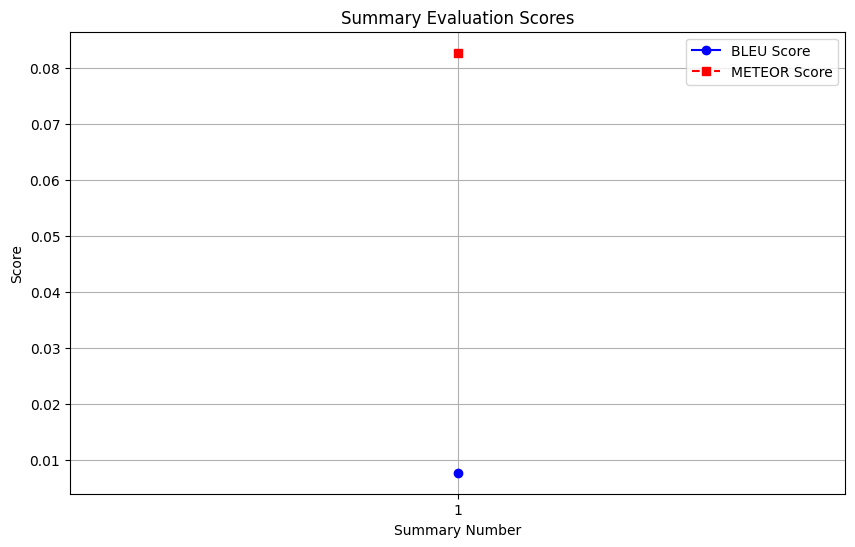

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


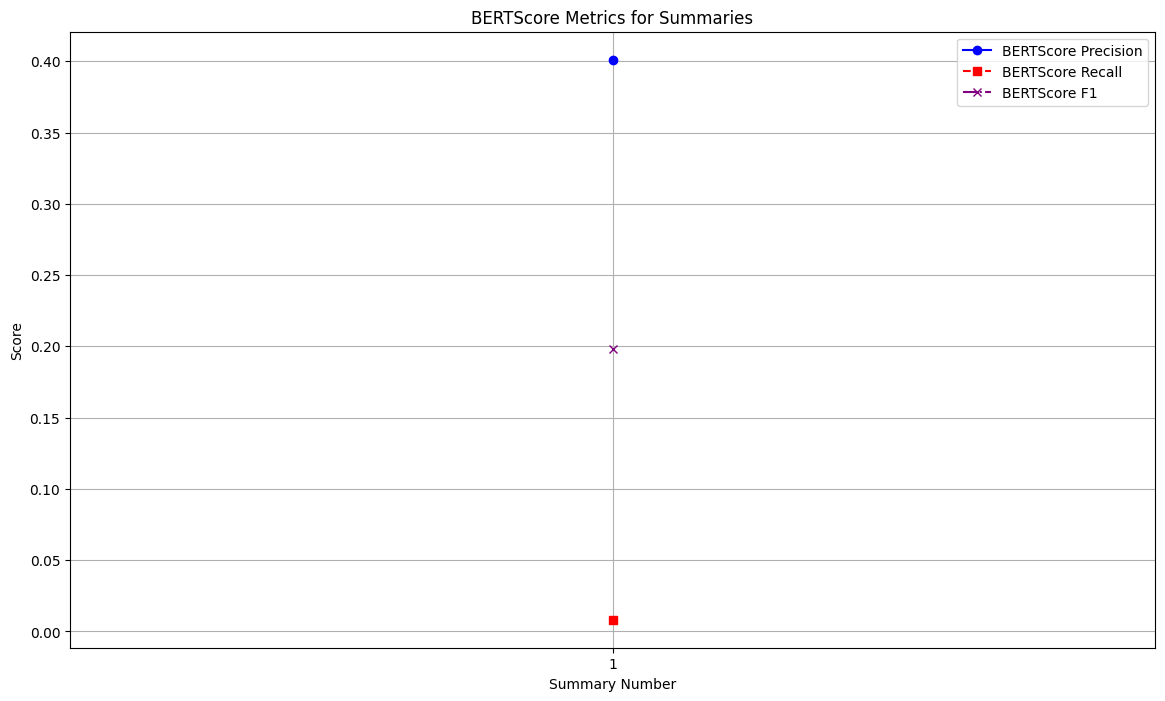

In [58]:
#Pegasus library evaluation values
evaluation_summary([pegasus_list[0]])

BLEU Scores:
Summary 1: 0.01972515084056995

METEOR Scores:
Summary 1: 0.1855915034186481


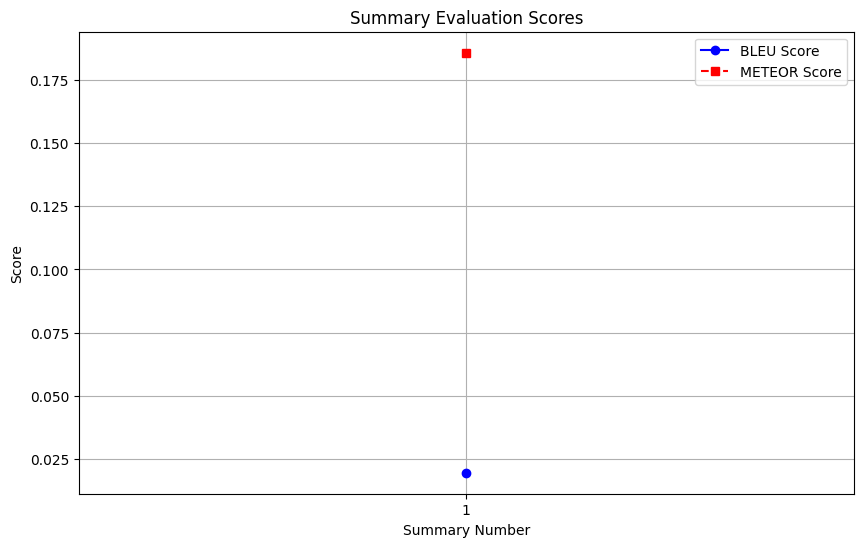

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


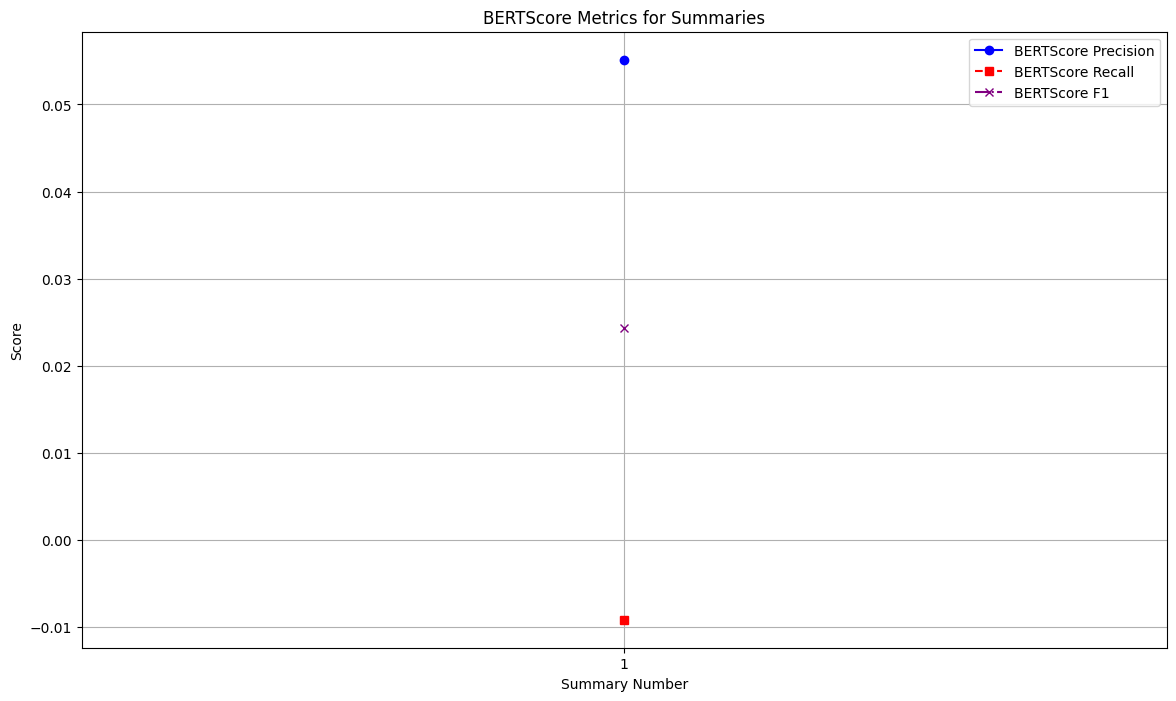

In [59]:
#T5 library evaluation values
evaluation_summary([T5_list[0]])

BLEU Scores:
Summary 1: 0.05601748457840769

METEOR Scores:
Summary 1: 0.23643142530807484


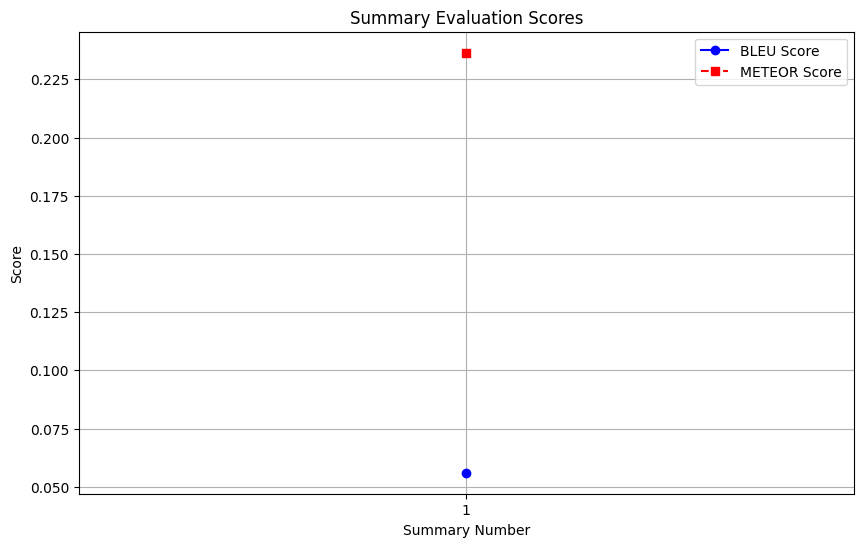

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


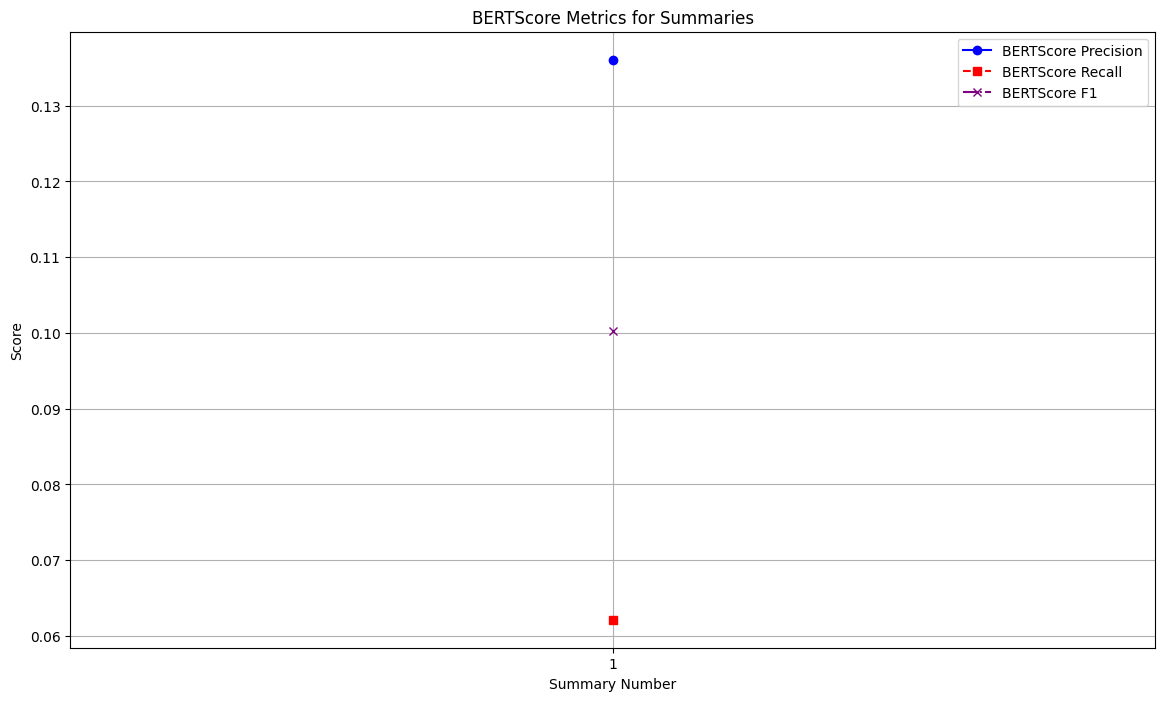

In [60]:
#SBERT library evaluation values
evaluation_summary([SBERT_list[0]])

BLEU Scores:
Summary 1: 0.0661030508277771

METEOR Scores:
Summary 1: 0.34865100087032197


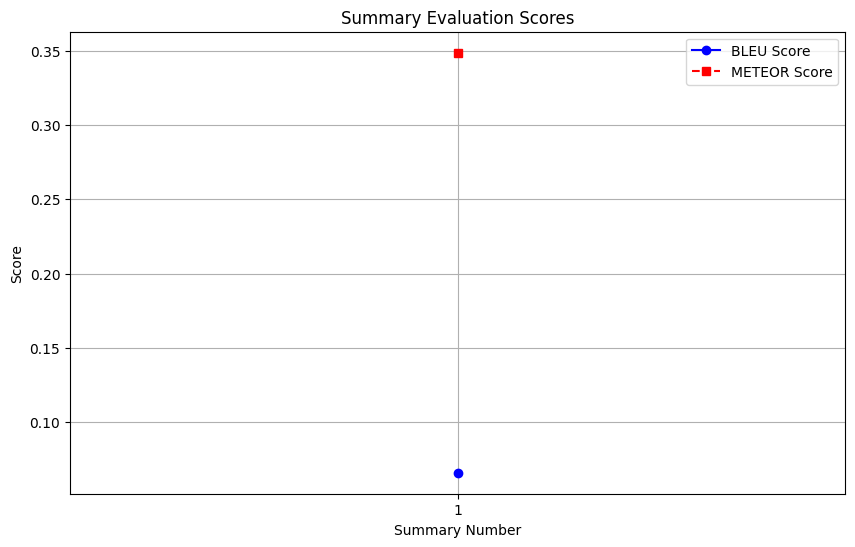

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


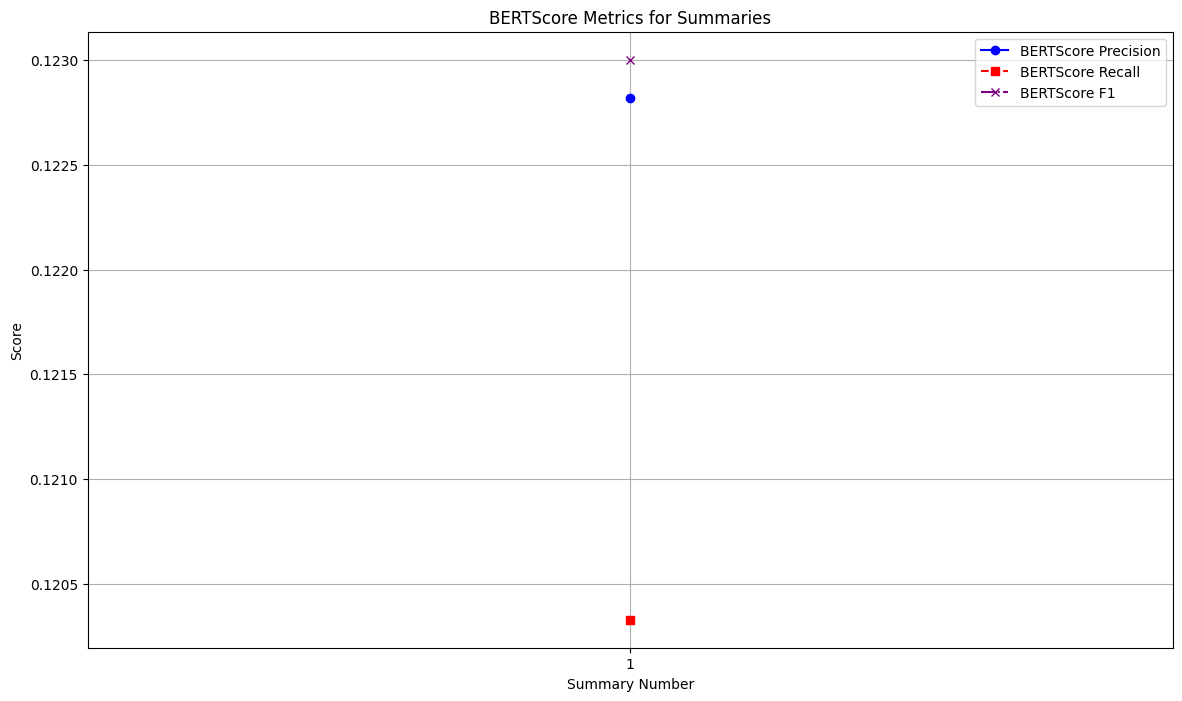

In [61]:
#BERTSUM library evaluation values
evaluation_summary([BERTSUM_list[0]])

###2.5.d


In this section the summarization based on ratings system is builded.

In [62]:
# Seperating comments depending on their rates.
df1 = df[df["Ratings"]==1]
df2 = df[df["Ratings"]==2]
df3 = df[df["Ratings"]==3]
df4 = df[df["Ratings"]==4]
df5 = df[df["Ratings"]==5]

#Creating empty list the store rating based comment values
rating1_list =[]
rating2_list =[]
rating3_list =[]
rating4_list =[]
rating5_list =[]
total_rating_list =[]

#Storing all text variables in their lists in a proper way.
for i in range(len(df1)):
  rating1_list.append(''.join(df1.iloc[i,1]))
sss=""
for i in range(len(rating1_list)):
  sss += "".join(rating1_list[i])
total_rating_list.append(sss)
#Storing all text variables in their lists in a proper way.
for i in range(len(df2)):
  rating2_list.append(''.join(df2.iloc[i,1]))
sss=""
for i in range(len(rating2_list)):
  sss += "".join(rating2_list[i])
total_rating_list.append(sss)
#Storing all text variables in their lists in a proper way.
for i in range(len(df3)):
  rating3_list.append(''.join(df3.iloc[i,1]))
sss=""
for i in range(len(rating3_list)):
  sss += "".join(rating3_list[i])
total_rating_list.append(sss)
#Storing all text variables in their lists in a proper way.
for i in range(len(df4)):
  rating4_list.append(''.join(df4.iloc[i,1]))
sss=""
for i in range(len(rating4_list)):
  sss += "".join(rating4_list[i])
total_rating_list.append(sss)
#Storing all text variables in their lists in a proper way.
for i in range(len(df5)):
  rating5_list.append(''.join(df5.iloc[i,1]))
sss=""
for i in range(len(rating5_list)):
  sss += "".join(rating5_list[i])
total_rating_list.append(sss)



In [63]:
#Creating summary list empty initially.
pegasus_list_RATE = []
T5_list_RATE = []
SBERT_list_RATE = []
BERTSUM_list_RATE = []
#Take all the summary values and store them into their list.
pegasus_list_RATE,T5_list_RATE,SBERT_list_RATE,BERTSUM_list_RATE = summary_creator_4_model(total_rating_list,total_rating_list)
#Depending on the summaries titles are generated in the following function
general_title_generator(pegasus_list_RATE,T5_list_RATE,SBERT_list_RATE,BERTSUM_list_RATE,total_rating_list)
#This section can take upto 5-8 minutes please aware of this.


1. CLUSTER ORIGINAL TEXT: 

i expect like regular size of ring,but this one look like a ring for toy or something funy, the MM of our rings is 5MM and this ring may be is 1MMso ridiculousMartin1/5 ct.tw Round Diamond Solitaire Ring in 18k White GoldI ordered a ring that stated Toe Ring" in the description. The ring came very quickly but was not a toe ring. I don't know anyone with a size 8 toe. If you know anyone please direct them to this seller! Is it a wedding band, toe ring or thumb ring? Pick one!This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. I returned the ring for a replacement of the same ring, the second ring was even worse. Clearly visible white scratch right in the middle of a black diamond does not look that great. And this time 1 diamond missing on the shoulder of the ring. I returned it for a refund. Thanks alot Amazon.This ring is a beautiful ring but the first shipme

###2.5.e

In [68]:
#This interface is created to take a request sentence and retrivial most related
#Cluster them and generate summaries and titles for them

def summary_interface():

    # Create widgets
    sentence_input = widgets.Text(
        value='',
        placeholder='Enter a sentence to see summary in clustered',
        description='Sentence:',
        disabled=False
    )

    results_input = widgets.IntText(
        value=50,
        description='Num Results:',
        disabled=False
    )

    # Creating buttons
    submit_button = widgets.Button(description='Submit')
    exit_button = widgets.Button(description='Exit')

    # Function to handle button click event
    def on_button_click(b):
        # Clear the previous output
        clear_output(wait=True)

        # Take the values that user gives
        query_sentence = sentence_input.value
        num_results = results_input.value
        # Call function to process the query and display results
        try:
            #retrieval the most related indexes.
            init = retrieval(query_sentence, num_results)
            #Cluster all the retrieved indexes.
            rc_to_sum , rt_to_sum = clustering(init[0], init[1])
        except:
            #This except is added to avoid possible errors.
            print("Please give a larger number to be able to make better classification")
            print("\n"+"Since there is no sense to cluster less than 3 values")
        #clear screen before writing results.
        clear_output()
        #Display the interface structure again
        display(interface_box)
        #Arrange the data before make the summarization
        t_interface =""
        all_clustered_variable_interface=[]
        for s in range(len(rt_to_sum)):
          for i in range(len(rt_to_sum[s])):
            t_interface += (rt_to_sum[s][i])
          all_clustered_variable_interface.append(t_interface)
          t_interface =""
        #Give the information about process.
        print("Number of Clusters: " +str(rc_to_sum)+"\n")
        print("Please wait for the responses it could take up to 5 minutes."+"\n")
        #Creating summaries
        pegasus_list_interface,T5_list_interface,SBERT_list_interface,BERTSUM_list_interface = summary_creator_4_model(all_clustered_variable_interface,rt_to_sum)
        #Creating titles
        general_title_generator(pegasus_list_interface,T5_list_interface,SBERT_list_interface,BERTSUM_list_interface,all_clustered_variable_interface)
    # Function to handle exit button click event
    def on_exit_click(b):
        # Clear the previous output
        clear_output(wait=True)
        # Close widgets
        submit_button.close()
        exit_button.close()
        sentence_input.close()
        results_input.close()
        print("Exited")

    # Attach button click event handlers
    submit_button.on_click(on_button_click)
    exit_button.on_click(on_exit_click)

    # Arrange buttons in a horizontal box layout
    buttons_box = widgets.HBox([submit_button, exit_button])

    # Arrange widgets in a vertical box layout
    interface_box = widgets.VBox([sentence_input, results_input, buttons_box])

    # Display the interface
    display(interface_box)

# Call the interface function
summary_interface()


1. CLUSTER ORIGINAL TEXT: 

i do love this ring and i wear it all the time. i bought it to wear when my husband and i go on vacation so i don't have to worry about losing my real ring. the stone is already lose but it is a $50 ring and not a $5000 ring. almost every time i leave the house i get a compliment on this ring. my mom cannot tell the different between this ring and my real wedding ring. it is a little bulkier then the picture leads one to believe, but it is still a wonderful ring. if anything happens and the stone does fall out, i will probably buy another ring because of how much i love this ring.i reciently lost a ring very much like this one and was searching high and low for another ring to replace the one i lost and came across this ring. this ring is absolutely the most brilliant ring to look at. it shines and sparkels like little diamonds. i just love this ring. and would reccomend it to anyone who wants a ring that is elegent and afordable at the same time.my fiance 

All process finished.